# Abberation mapping workflow 1: Process patches #

*25 Jan 2023*

*11 September 2023*

*27 September 2023*

Originally by Debayan Saha.  Jamie White modified Debayan's notebooks. 

Updating for Jamie's environment on the cluster.

Documenting installation / file locations.

Updating to run notebooks locally on a Mac / PC.  The psf modeling is super compute intensive, so it needs to be done on the cluster. Strategy: execute cluster commands via ssh.

## Environment paths ##

Not necessary in local non-cuda environment; transfer these to script executed via ssh.

In [1]:
# # not necessary for running locally on a mac  
# %env PATH=/sw/ap|ps/python3/3.7.4/bin:/sw/apps/jupyter-tensorboard/0.1.6/bin:/sw/apps/hdf5/1.8.16/bin:/sw/apps/cuda/10.0.130/bin:/sw/bin:/usr/lib64/qt-3.3/bin:/sbin:/bin:/usr/sbin:/usr/bin
# %env LD_LIBRARY_PATH=/sw/apps/python3/3.7.4/lib:/sw/apps/hdf5/1.8.16/lib:/sw/apps/cuda/10.0.130/lib64:/sw/apps/cuda/10.0.130/lib:/sw/lib

In [2]:
# ! env

## Load packages ##

In [293]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(".")
# sys.path.append('/home/dsaha/.local/lib/python3.7/site-packages/')
from main import *
import os
import shlex
import paramiko
import tifffile
import shutil
import warnings
import tqdm
from IPython.display import display, clear_output
from time import sleep

In [4]:
warnings.filterwarnings(action='once')
%load_ext autoreload
%autoreload 2

### Files ###
|
Change the files for the experiment here.

In [350]:
# relative path to bead image stack
image_file = "data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/beads.tif"

In [351]:
# ImageJ executable location on **cluster**
remote_fiji_path = '/home/jwhite/fiji/Fiji.app/ImageJ-linux64'
# project location on cluster
# project files are relative to this location
# and should be duplicated on the local machine
remote_project_base_path = '/home/jwhite/projects/aberration_mapping/'
# macro location: relative, for both machines
fiji_macro_dir  =  "imageJ_macros/" 
# select proper macro 
fiji_macro      = 'zola_macro_cluster_params_passed.ijm'# path to custom macros for running on cluster

In [352]:
# script for starting zola analysis on cluster
zola_script_dir = 'scripts/'
# script to use
# bashscript_fiji3.sh currently accepts paramters defined in this notebook and does not need to be edited for each analysis
zola_script     = 'bashscript_fiji3.sh'

### Parameters ###

Change the paramters for the experiment here.

In [353]:
# set new parameters
crop_shape      = [40, 40, 40]
unit            = [0.05, 0.2, 0.2]
abb_list        = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
thresh_bck      = 10
num_folders     = 50
thresh_dist     = 11.29999999999999999999999999999999999
lam             = 0.515

# for psf macro
pixel_size           = 100 # pixel size in nanometers
z_step               = 50 # spacing of the z-slices, in nanometers
bead_moving          = "far -> close to objective"
immersion_refractive = 1.33
numerical_aperture   = 1.2  # NA of objective used to image beads
patch_size           = 64
zernike_coefficient  = "Zernike 15 coefs"
iteration            = 100

In [354]:
# construct parameter string for the psf modeling ImageJ plugin 
# to be called on a gpu node of the HPC cluster by slurm
'''
run(" Calibration: PSF modeling", " run_on_gpu gain=1 pixel_size=100 z_step=50 bead_moving=[{bead_moving}] numerical_aperture=1.2 immersion_refractive=1.33 wavelength={lam} patch_size="+wid+" zernike_coefficient=[Zernike 15 coefs] iteration=100 result_calibration_file="+output);
'''
#use the gpu
imageJ_macro_parameters = f'run_on_gpu gain=1 pixel_size={pixel_size} z_step={z_step} bead_moving=[{bead_moving}] numerical_aperture={numerical_aperture} immersion_refractive={immersion_refractive} wavelength={lam} patch_size={patch_size} zernike_coefficient=[{zernike_coefficient}] iteration={iteration} result_calibration_file='
# no gpu
# imageJ_macro_parameters = f'gain=1 pixel_size={pixel_size} z_step={z_step} bead_moving=[{bead_moving}] numerical_aperture={numerical_aperture} immersion_refractive={immersion_refractive} wavelength={lam} patch_size={patch_size} zernike_coefficient=[{zernike_coefficient}] iteration={iteration} result_calibration_file='

imageJ_macro_parameters = f"\"{imageJ_macro_parameters}\""
print(imageJ_macro_parameters)
# spaces are causing problems when passed to command line, so use "Q" as a spacer
# the > is also problematic, repace with R
imageJ_macro_parameters = imageJ_macro_parameters.replace(" ", "Q").replace(">", "R")
imageJ_macro_parameters

"run_on_gpu gain=1 pixel_size=100 z_step=50 bead_moving=[far -> close to objective] numerical_aperture=1.2 immersion_refractive=1.33 wavelength=0.515 patch_size=64 zernike_coefficient=[Zernike 15 coefs] iteration=100 result_calibration_file="


'"run_on_gpuQgain=1Qpixel_size=100Qz_step=50Qbead_moving=[farQ-RQcloseQtoQobjective]Qnumerical_aperture=1.2Qimmersion_refractive=1.33Qwavelength=0.515Qpatch_size=64Qzernike_coefficient=[ZernikeQ15Qcoefs]Qiteration=100Qresult_calibration_file="'

## Utility functions ##

In [10]:
def pretty_print_dict(d):
    print(json.dumps(d, indent=4))
    
def min_max_norm(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

## Initialize paramiko for ssh and sftp connections

In [11]:
# SSH Configuration
hostname = 'falcon'
port = 22  # default SSH port, change if needed
username = 'jwhite'
# 
# local_file_path = '~/data/mydatafile.txt'
# remote_file_path = '~/data/mydatafile.txt'

# Use the private key for authentication
private_key_path = os.path.expanduser("~/.ssh/id_rsa")
private_key = paramiko.RSAKey(filename=private_key_path)

# Initialize SSH client
ssh_client = paramiko.SSHClient()
ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())  # auto-accept the server's host key

___

## Generate additional files and parameters ##

The notebook assumes everything is set locally and tries to reproduce the local project space on the remote `falcon` using the `paramiko` python package.

## Construct local filepaths ##

From current working directory. 

In [12]:
local_base_path = os.getcwd()+'/' # everything relative to the notebook directory
local_base_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/'

In [13]:
local_fiji_macro_path = f'{local_base_path}{fiji_macro_dir}{fiji_macro}'
local_fiji_macro_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm'

In [14]:
# construct full path to image file and set save directory
local_img_path  = f"{local_base_path}{image_file}"
local_img_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/beads.tif'

In [15]:
# file_path and save_dir variables for compatibility
local_data_file_path = os.path.dirname(local_img_path) +'/'
Local_save_dir  = local_data_file_path
local_data_file_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/'

In [16]:
local_zola_script_path = f"{local_base_path}{zola_script_dir}{zola_script}"
local_zola_script_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/scripts/bashscript_fiji3.sh'

In [51]:
local_patches_path= f'{local_data_file_path}patches_for_zola/'
local_patches_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/patches_for_zola/'

## Construct remote filepaths ##

In [17]:
remote_project_base_path

'/home/jwhite/projects/aberration_mapping/'

In [18]:
remote_image_file_path = f"{remote_project_base_path}{image_file}"
remote_image_file_path

'/home/jwhite/projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/beads.tif'

In [19]:
remote_fiji_macro_path = f'{remote_project_base_path}{fiji_macro_dir}{fiji_macro}'
remote_fiji_macro_path

'/home/jwhite/projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm'

In [20]:
# construct full path to image file and set save directory
remote_img_path  = f"{remote_project_base_path}{image_file}"
remote_img_path

'/home/jwhite/projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/beads.tif'

In [21]:
# file_path and save_dir variables for compatibility
remote_data_file_path = os.path.dirname(remote_img_path) +'/'
remote_save_dir  = remote_data_file_path
remote_data_file_path

'/home/jwhite/projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/'

In [22]:
remote_zola_script_path = f"{remote_project_base_path}{zola_script_dir}{zola_script}"
remote_zola_script_path

'/home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji3.sh'

In [50]:
remote_patches_path = f'{remote_data_file_path}patches_for_zola/'
remote_patches_path

'/home/jwhite/projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/patches_for_zola/'

## Construct new parameters dictionary ##

In [23]:
# parameters
new_parameters = {}

new_parameters['crop_shape']      = crop_shape
new_parameters['unit']            = unit
new_parameters['abb_list']        = abb_list
new_parameters['FIJI_MACRO_PATH'] = remote_fiji_macro_path
new_parameters['thresh_bck']      = thresh_bck
new_parameters['num_folders']     = num_folders
new_parameters['thresh_dist']     = thresh_dist
new_parameters['lam']             = lam
new_parameters

{'crop_shape': [40, 40, 40],
 'unit': [0.05, 0.2, 0.2],
 'abb_list': [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'FIJI_MACRO_PATH': '/home/jwhite/projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm',
 'thresh_bck': 10,
 'num_folders': 50,
 'thresh_dist': 11.3,
 'lam': 0.515}

## Make sure everything we need is on the remote

In [24]:
# local project space will be reconstructed relative to this directory on the remote
remote_project_base_path

'/home/jwhite/projects/aberration_mapping/'

In [25]:
# compare to local project space
local_base_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/'

In [26]:
# check that the project folder is the same on both systems
local_project_check = local_base_path.split('/')[-2]
remote_project_check = remote_project_base_path.split('/')[-2]
assert local_project_check == remote_project_check,  "Local and remote base project spaces are not the same.  Are you sure about this?"

In [27]:
# copy local files over if they are not there already

local_file_paths = [
    local_img_path,
    local_fiji_macro_path,
    local_zola_script_path
]

remote_file_paths = [
    remote_image_file_path,
    remote_fiji_macro_path,
    remote_zola_script_path
]

# open ssh connection
ssh_client.connect(hostname, port, username, pkey=private_key)

# Initialize SFTP client
sftp_client = ssh_client.open_sftp()

# check for ImageJ on remote

try:
    sftp_client.stat(remote_fiji_path)
    print(f"Using {remote_fiji_path} on the remote system {hostname}")
    print()
except FileNotFoundError:
    print(f"Cannot find {remote_fiji_path} on {hostname}.  Perhaps it is not installed?")
    print()
    
    
for local, remote in list(zip(local_file_paths, remote_file_paths)):
    # 1. Check if the remote file exists
    try:
        sftp_client.stat(remote)
        print(f"Remote file \n {remote} \nalready exists. Nothing copied.")
    except FileNotFoundError:
     # 2. If it does not exist, copy the local file to the remote location
        sftp_client.put(local, remote)
        print(f"Local file {local} copied to {remote} on the remote server.")
    
# Close the clients
sftp_client.close()
ssh_client.close()

Using /home/jwhite/fiji/Fiji.app/ImageJ-linux64 on the remote system falcon

Remote file 
 /home/jwhite/projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/beads.tif 
already exists. Nothing copied.
Remote file 
 /home/jwhite/projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm 
already exists. Nothing copied.
Remote file 
 /home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji3.sh 
already exists. Nothing copied.


## Fiji application and ImageJ macros

### Check Fiji macros ###

In [28]:
# # check current macro directory
# fiji_macro_dir

In [29]:
# fiji_macro_path

In [30]:
# # check available macros
# ! ls -lga "{fiji_macro_dir}"

## Check old parameters if they exist

In [31]:
# # look at parameters from last processing job
# old_params = setup_param_file(local_img_path)
# type(old_params)
# old_params

## Load and show the image

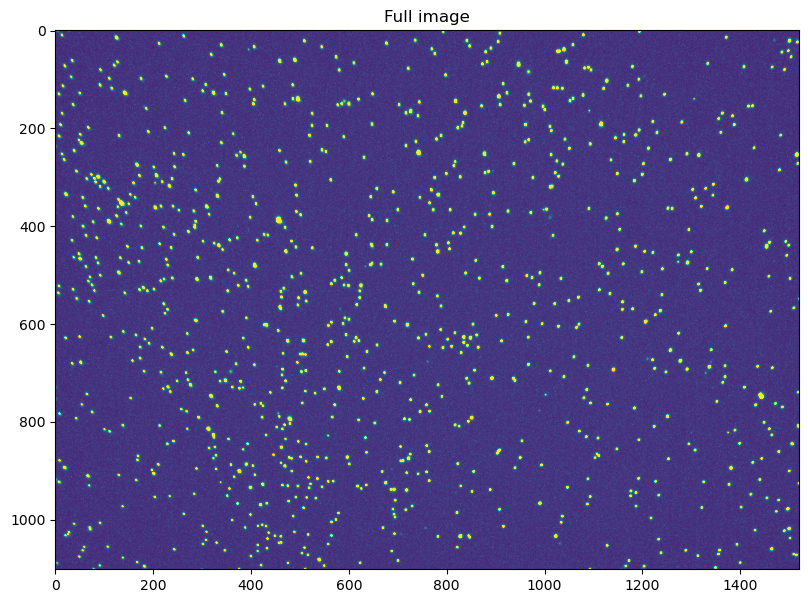

In [32]:
img = tifffile.imread(local_img_path)
img_max = np.max(img,0)

%matplotlib inline
fig, axs = plt.subplots(1,1,figsize=(10,7))
plt.imshow(img_max, clim=(np.percentile(img_max,0), np.percentile(img_max,99)))
plt.title("Full image");
# None;

## Load points from csv file and save patches

In [33]:
# from main import *
find_psf_crops(
    local_img_path, 
    crop_shape     = crop_shape, 
    num_folders    = num_folders, 
    thresh_bck     = thresh_bck, 
    threshold_dist = thresh_dist,
    unit           = unit,
    show_ignored   = False, 
    show_accepted  = False, 
    headless       = False
)

Found 942 points
Deleting 216 because points are too close
Deleting 54 because patches could not be cropped
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multiple labels in the cropbox
Deleting because of multi

## Load patches

In [34]:
# load the patches
patch_files = glob.glob(f"{os.path.dirname(local_img_path)}/patches_for_zola/patches*/planes_10_*.tif")
print(f"Found {len(patch_files)} patch files")
names = [os.path.splitext(os.path.basename(p))[0] for p in patch_files]
crops = {n: tifffile.imread(p) for n, p in zip(names, patch_files)}
pos = np.array([list(map(int, re.findall(r'\d+', n))) for n in names])
pos = pos[:,1:]

Found 626 patch files


In [35]:
patch_files[:2]

['/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/patches_for_zola/patches_34/planes_10_z_55_y_140_x_1305.tif',
 '/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/patches_for_zola/patches_34/planes_10_z_50_y_888_x_359.tif']

## Show the beads

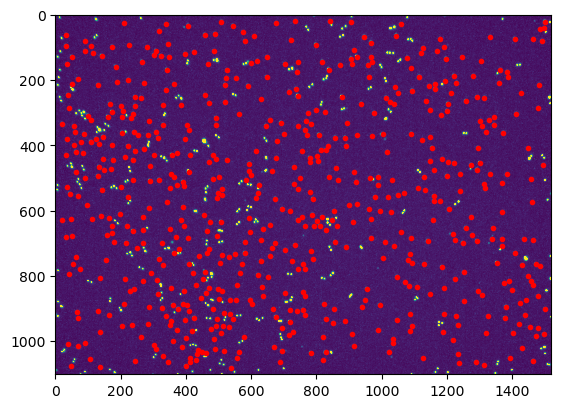

In [36]:
plt.imshow(img_max, clim=(np.percentile(img_max,3), np.percentile(img_max,99)))
plt.plot(pos[:,2], pos[:,1],'r.');

## Show each bead

planes_10_z_55_y_140_x_1305 127.0


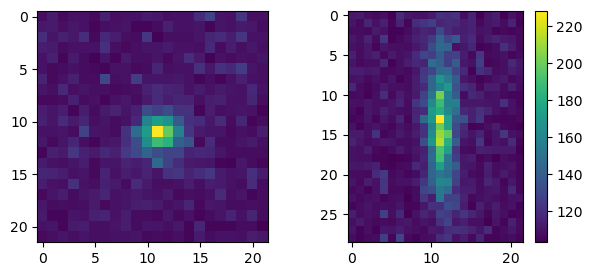

(29, 22, 22)
planes_10_z_50_y_888_x_359 418.0


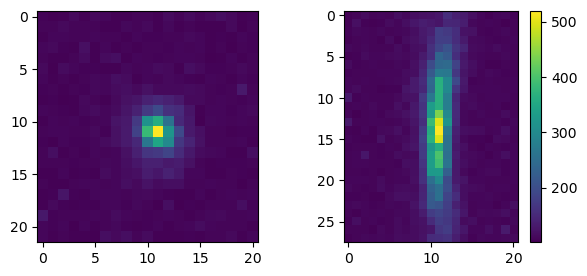

(28, 22, 21)
planes_10_z_56_y_54_x_574 507.0


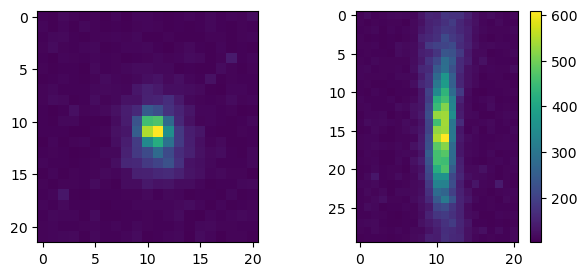

(30, 22, 21)
planes_10_z_50_y_743_x_64 277.0


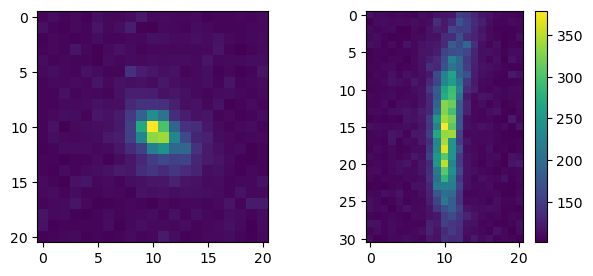

(31, 21, 21)
planes_10_z_58_y_64_x_1044 608.0


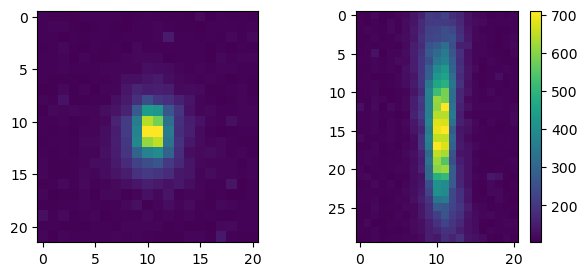

(30, 22, 21)
planes_10_z_50_y_932_x_496 461.0


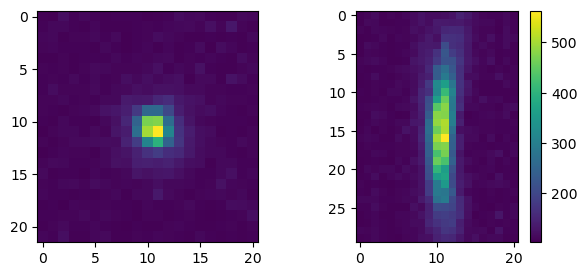

(30, 22, 21)
planes_10_z_52_y_359_x_309 836.0


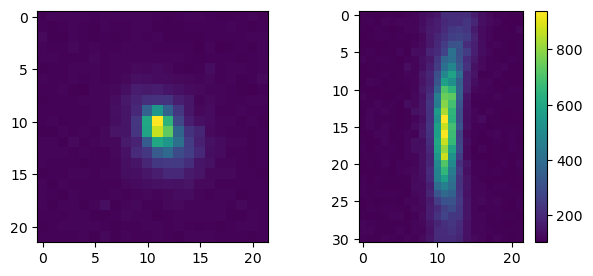

(31, 22, 22)
planes_10_z_54_y_730_x_1408 470.0


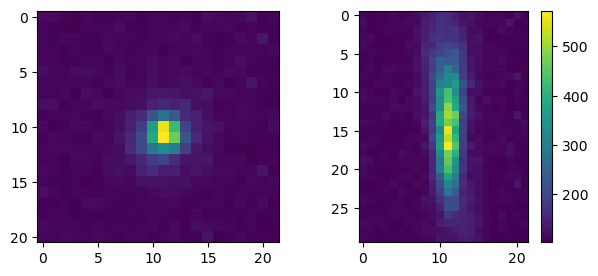

(30, 21, 22)
planes_10_z_52_y_923_x_1325 405.0


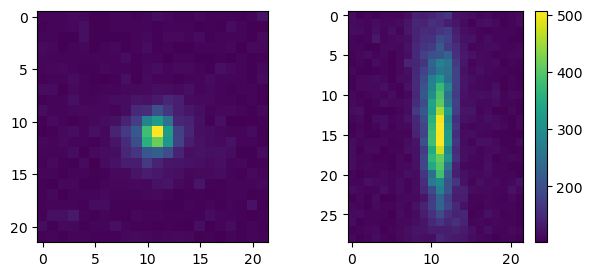

(29, 22, 22)
planes_10_z_50_y_564_x_788 474.0


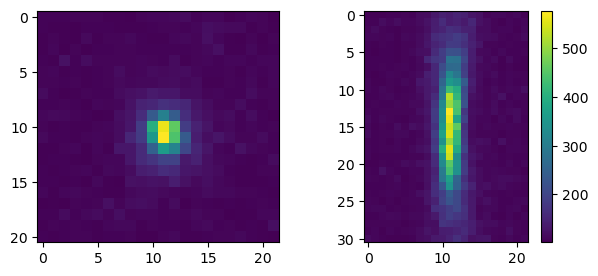

(31, 21, 22)
planes_10_z_52_y_558_x_978 589.0


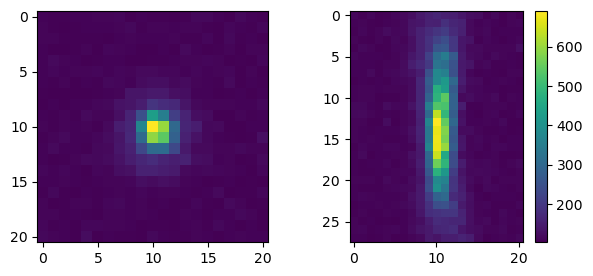

(28, 21, 21)
planes_10_z_57_y_91_x_798 482.0


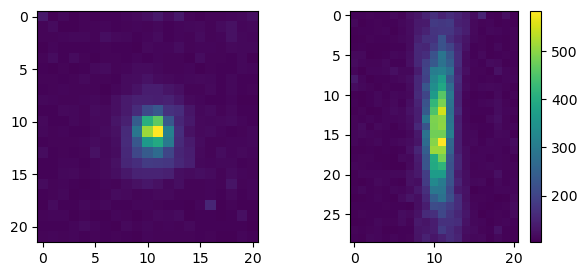

(29, 22, 21)
planes_10_z_55_y_667_x_1060 531.0


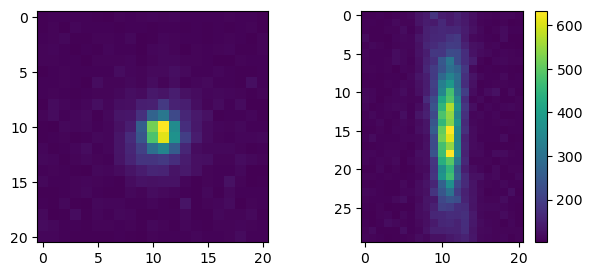

(30, 21, 21)
planes_10_z_54_y_336_x_782 754.0


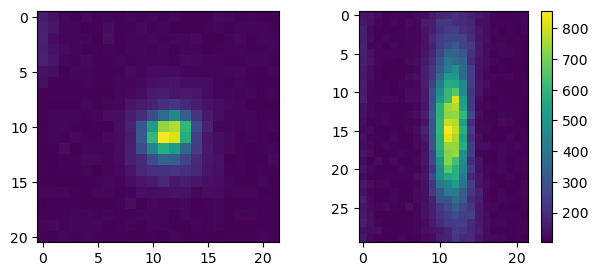

(30, 21, 22)
planes_10_z_50_y_1014_x_916 544.0


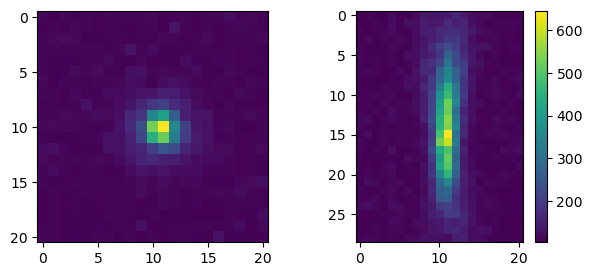

(29, 21, 21)
planes_10_z_55_y_232_x_1093 588.0


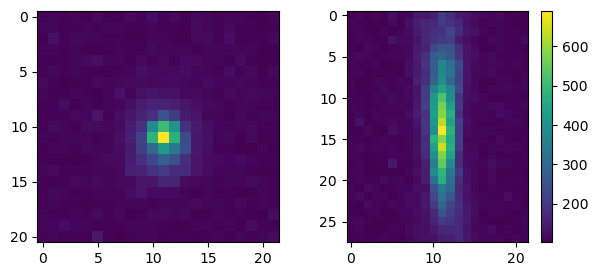

(28, 21, 22)
planes_10_z_52_y_628_x_848 1035.0


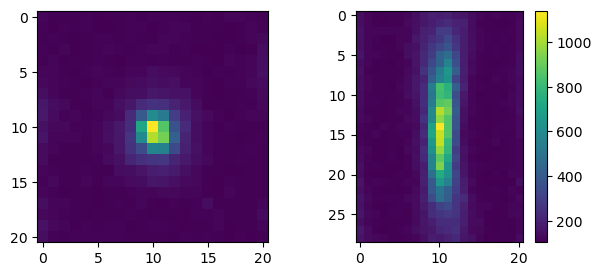

(29, 21, 21)
planes_10_z_54_y_619_x_1274 532.0


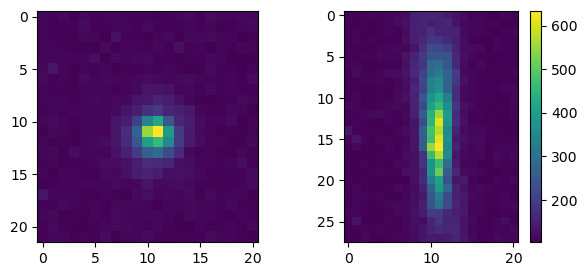

(28, 22, 21)
planes_10_z_53_y_359_x_61 344.0


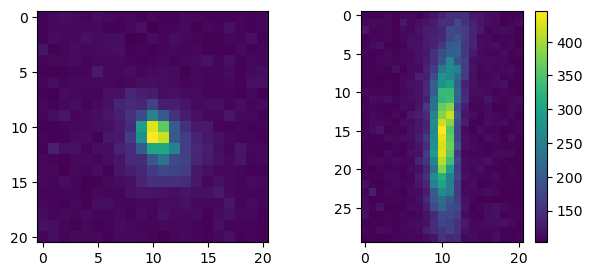

(30, 21, 21)
planes_10_z_49_y_815_x_270 269.0


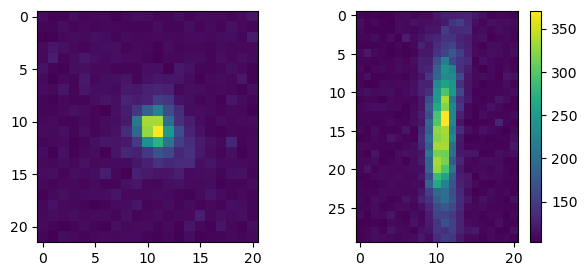

(30, 22, 21)
planes_10_z_50_y_1034_x_1023 943.0


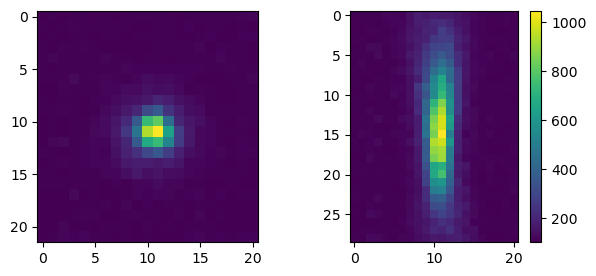

(29, 22, 21)
planes_10_z_50_y_697_x_181 380.0


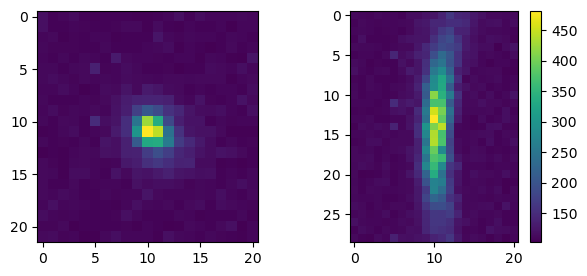

(29, 22, 21)
planes_10_z_50_y_905_x_718 428.0


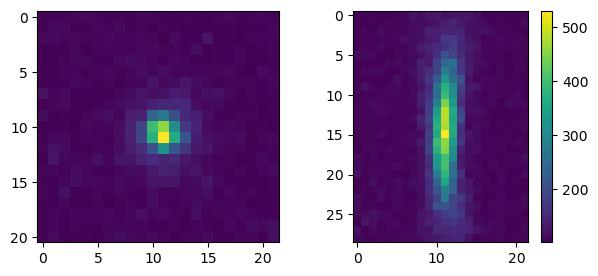

(29, 21, 22)
planes_10_z_54_y_128_x_50 265.0


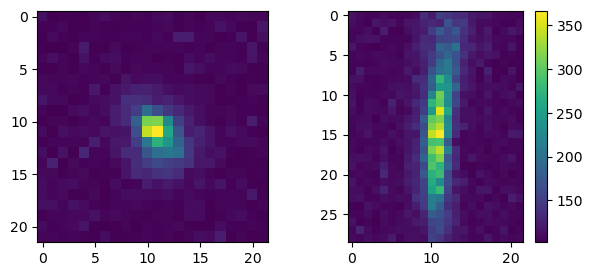

(29, 22, 22)
planes_10_z_51_y_937_x_355 357.0


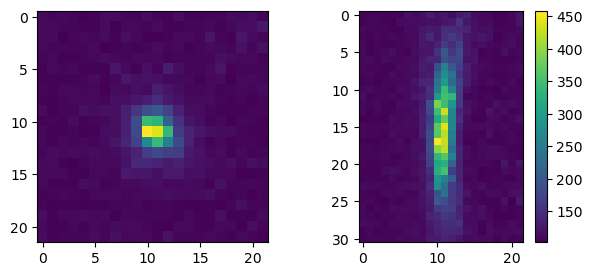

(31, 22, 22)
planes_10_z_53_y_444_x_177 429.0


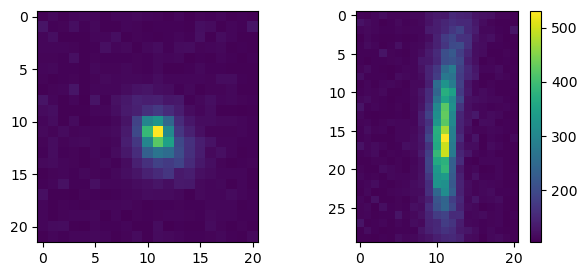

(30, 22, 21)
planes_10_z_54_y_376_x_314 362.0


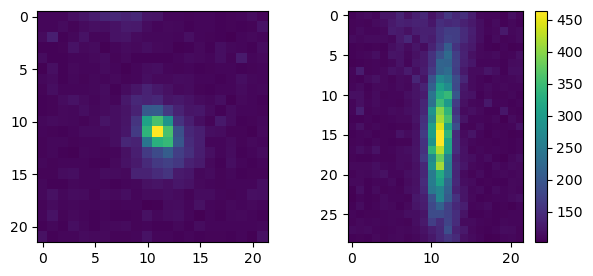

(29, 22, 22)
planes_10_z_53_y_211_x_364 313.0


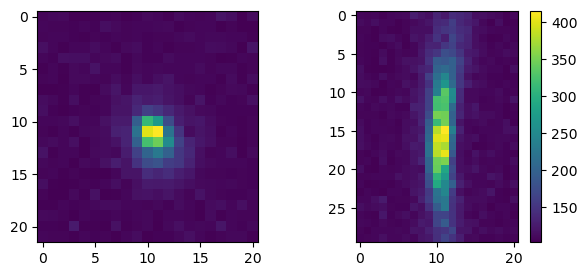

(30, 22, 21)
planes_10_z_55_y_414_x_828 621.0


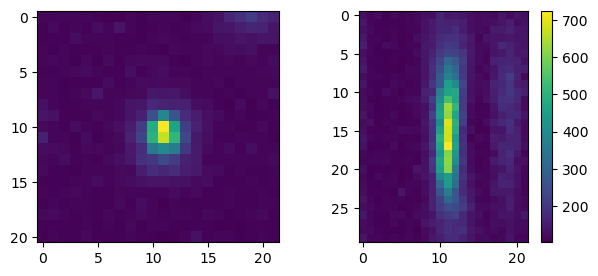

(30, 21, 22)
planes_10_z_52_y_396_x_135 280.0


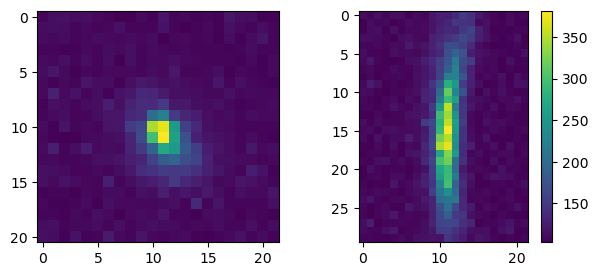

(30, 21, 22)
planes_10_z_53_y_559_x_1020 536.0


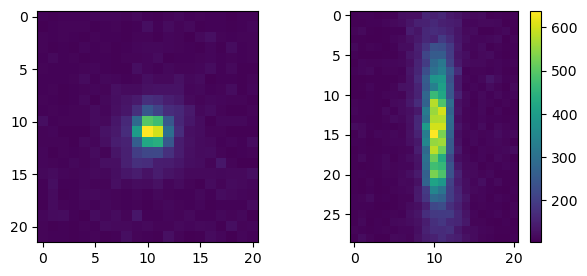

(29, 22, 21)
planes_10_z_54_y_531_x_1318 519.0


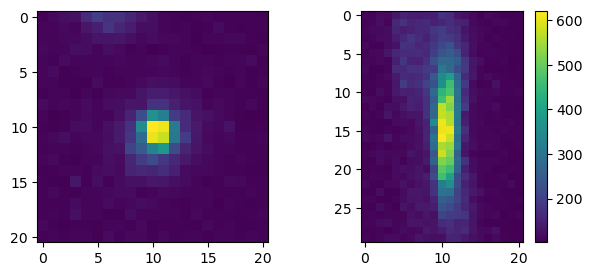

(30, 21, 21)
planes_10_z_53_y_417_x_243 355.0


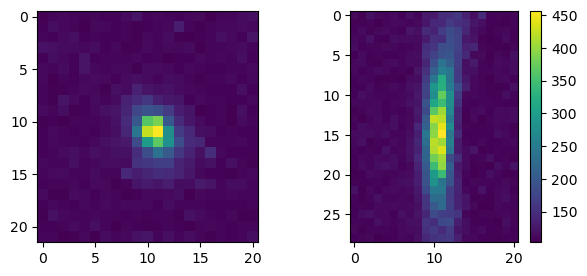

(29, 22, 21)
planes_10_z_53_y_334_x_21 566.0


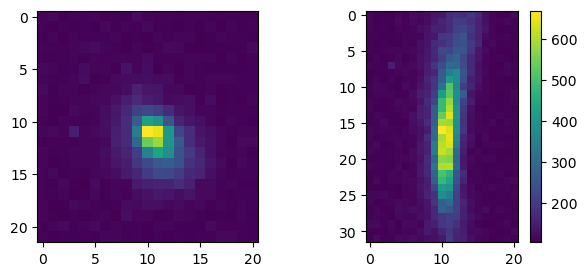

(32, 22, 21)
planes_10_z_53_y_198_x_68 300.0


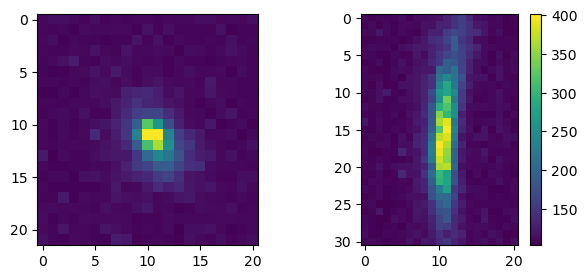

(31, 22, 21)
planes_10_z_56_y_330_x_690 583.0


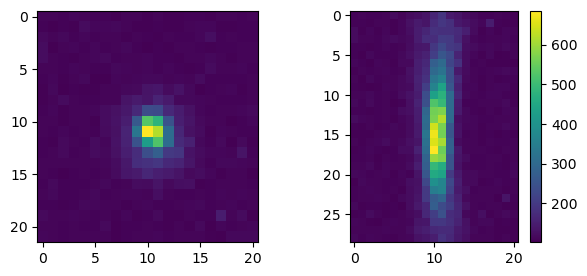

(29, 22, 21)
planes_10_z_50_y_779_x_765 458.0


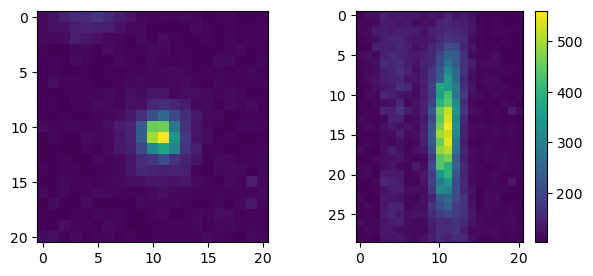

(29, 21, 21)
planes_10_z_51_y_896_x_288 329.0


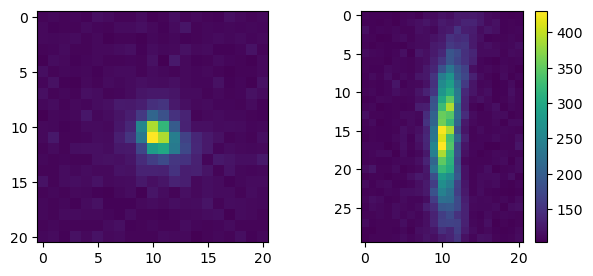

(30, 21, 21)
planes_10_z_56_y_130_x_968 531.0


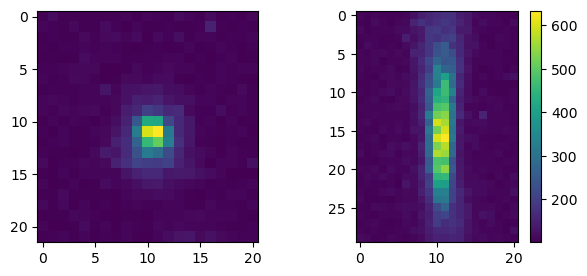

(30, 22, 21)
planes_10_z_53_y_493_x_1199 448.0


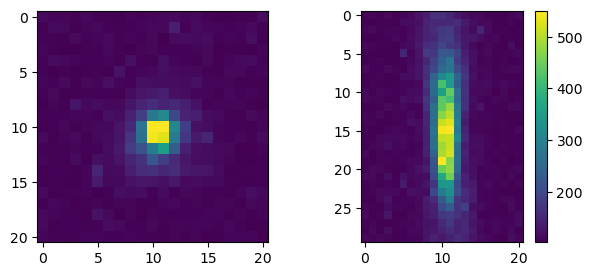

(30, 21, 21)
planes_10_z_53_y_222_x_1041 482.0


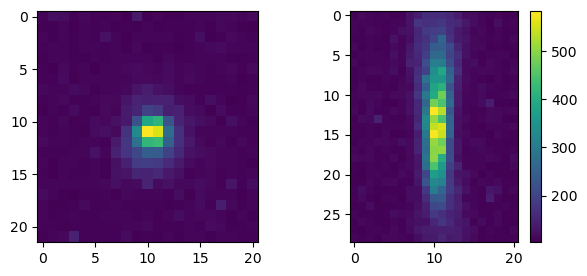

(29, 22, 21)
planes_10_z_54_y_129_x_348 388.0


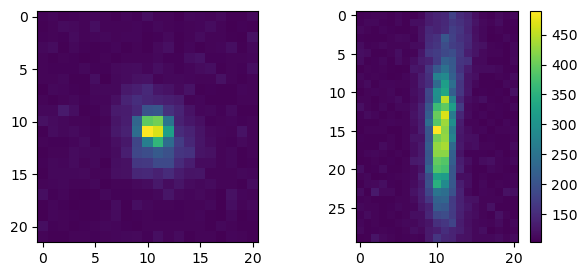

(30, 22, 21)
planes_10_z_57_y_22_x_905 488.0


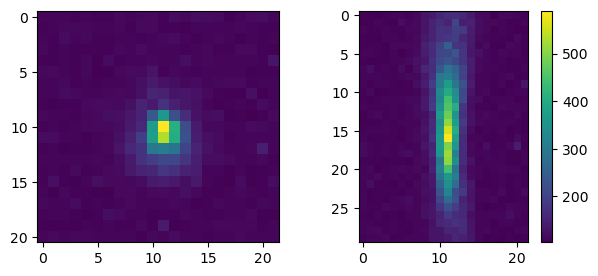

(30, 21, 22)
planes_10_z_53_y_631_x_802 433.0


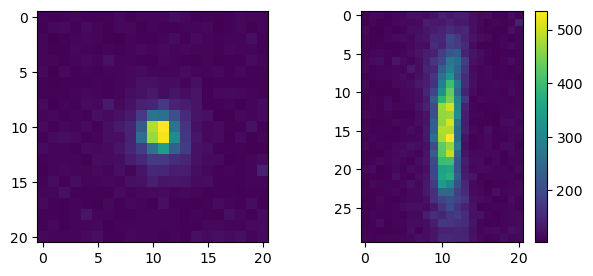

(30, 21, 21)
planes_10_z_54_y_95_x_33 252.0


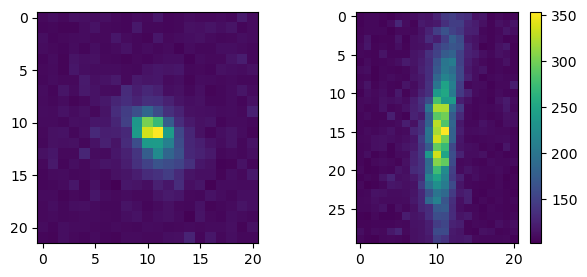

(30, 22, 21)
planes_10_z_51_y_730_x_580 1022.0


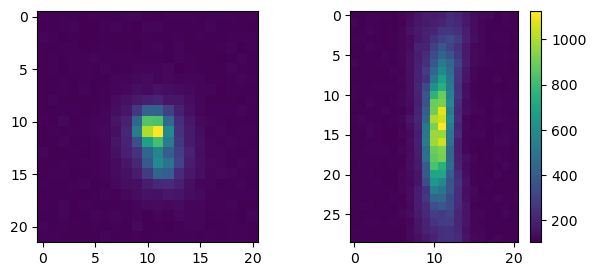

(29, 22, 21)
planes_10_z_55_y_109_x_915 490.0


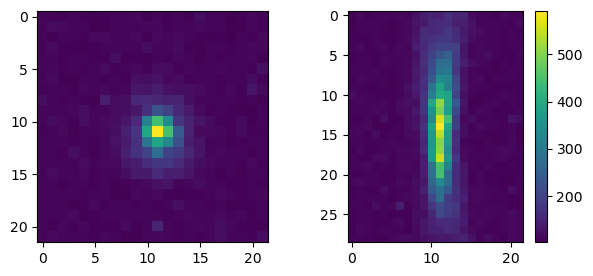

(29, 22, 22)
planes_10_z_50_y_914_x_517 355.0


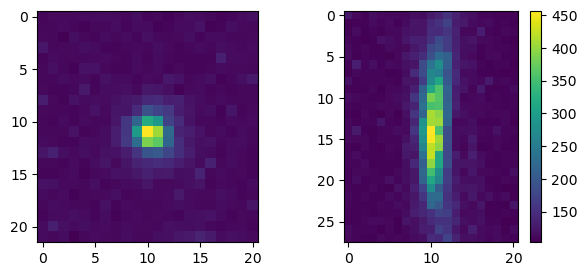

(28, 22, 21)
planes_10_z_49_y_1039_x_434 374.0


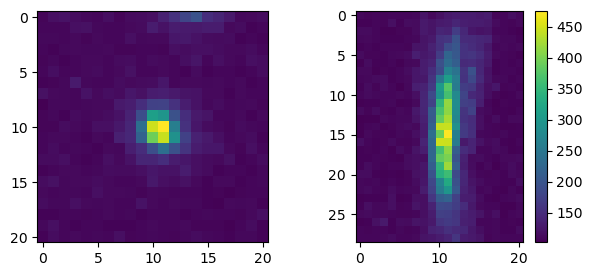

(29, 21, 21)
planes_10_z_51_y_973_x_137 262.0


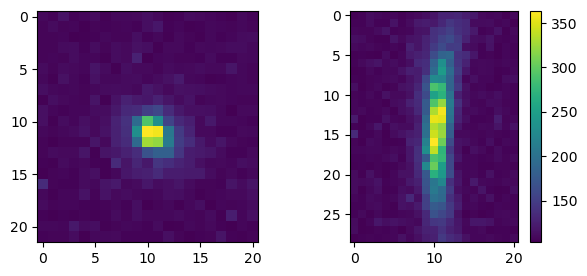

(29, 22, 21)


In [37]:
i=0
for n,pat in crops.items():
    zz,yy,xx = pat.shape
    x_arr = np.arange(-1*yy//2, yy//2)
    z_arr = np.arange(-1*zz//2, zz//2)
    fig, axs = plt.subplots(1,2,figsize=(7,3))
    print(n, np.max(pat) - np.median(pat))
    # print(shannon_entropy(pat))
    axs[0].imshow(np.max(pat,0))
    im = axs[1].imshow(np.max(pat,1))
    plt.colorbar(im)
    plt.show()
    print(pat.shape)
    i=i+1
    if i==50:
        break
None;

## Plot the signal-to-noise distribution

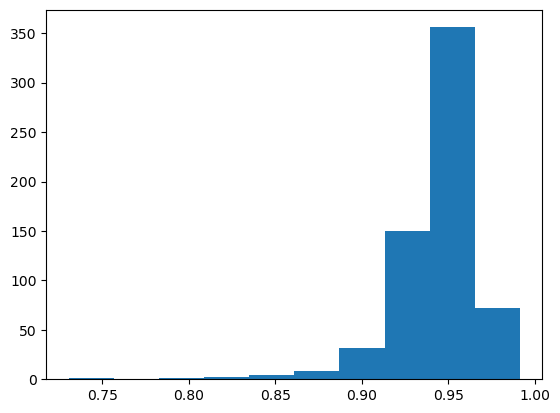

In [38]:
snr = []
for key,val in crops.items():
    val = min_max_norm(val)
    snr.append(np.max(val) - np.median(val))
snr = np.array(snr)
plt.hist(snr.flatten());

## Run Zola macro via bash command on the remote

Runs via ssh on the remote cluster: CBG HPC.

Calls a macro to run an ImageJ plugin on gpu nodes of the HPC cluster in headless batch mode. 

Uses `https://github.com/imodpasteur/ZOLA-3D` plugin: put the file

`ZOLA_-0.2.8-SNAPSHOT.jar`

into the plugins directory.

Uses the ImageJ executable stored in the variable 'remote_fiji_path'

Feeds the paramters and file locations to the macro, so no need to modify the macro for each experiment.

**Logistics**

1. Copy the folder `patches_for_zola` to the remote using ssh (needs to be set up with ssh passkeys between local and remote (falcon). Remove the `patches_for_zola` folder from the remote before copying, if it exists. 
2. slurm calls a bashscript shell script to initialize processes on the cluster: <br> `sbatch {remote_project_path}/scripts/bashscript3.sh`
2. In turn, the bash script sets up slurm jobs on gpu nodes of the cluster and calls ImageJ to run a macro stored in the variable `remote_fiji_macro_path` in headless batch mode.
3. The ImageJ macro runs the "Calibration: PSF modeling" plugin from the with the parameters stored in the `imageJ_macro_parameters` variable.  The macro should **not** need to be modified for each experiment.
4. The ImageJ plugin models the zola_raw data for each bead in the `zola_raw` folder
5. Copy the `zola_raw` folder from the cluster to the local machine using sftp and paramiko.  
 

In [60]:
# remove remote patches folder & files
! ssh falcon "rm -r {remote_patches_path}"

In [61]:
# ! ls -lga "{local_patches_path}"

In [62]:
! scp -r "$local_patches_path" falcon:$remote_data_file_path

planes_12_z_50_y_932_x_496.tif                100%   67KB   4.0MB/s   00:00    
planes_14_z_56_y_54_x_574.tif                 100%   75KB   4.7MB/s   00:00    
planes_10_z_55_y_140_x_1305.tif               100%   60KB   4.8MB/s   00:00    
planes_12_z_56_y_54_x_574.tif                 100%   67KB   5.6MB/s   00:00    
planes_12_z_58_y_64_x_1044.tif                100%   67KB   5.6MB/s   00:00    
planes_10_z_50_y_888_x_359.tif                100%   55KB   5.1MB/s   00:00    
planes_12_z_55_y_140_x_1305.tif               100%   68KB   4.9MB/s   00:00    
planes_10_z_56_y_54_x_574.tif                 100%   59KB   5.0MB/s   00:00    
planes_12_z_50_y_743_x_64.tif                 100%   66KB   6.5MB/s   00:00    
planes_14_z_55_y_140_x_1305.tif               100%   76KB   4.3MB/s   00:00    
planes_10_z_50_y_743_x_64.tif                 100%   59KB   5.3MB/s   00:00    
planes_14_z_50_y_888_x_359.tif                100%   71KB   5.5MB/s   00:00    
planes_12_z_52_y_359_x_309.tif          

### Troubleshooting ###

**Test Deb's ImageJ macro**

Note: to use the "run_on_gpu" option for the zola Fiji plugin in this line of the macro:

```python

	run(" Calibration: PSF modeling", "run_on_gpu gain=1 pixel_size=100 z_step=50 bead_moving=[far -> close to objective] numerical_aperture=1.2 immersion_refractive=1.33 wavelength=0.515 patch_size="+wid+" zernike_coefficient=[Zernike 15 coefs] iteration=100 result_calibration_file="+output);
```

you need to be logged into a gpu system on the cluster or implement the bashscript_fiji.sh (and derivatives) with sbatch on cluster (the script requests a gpu).

In [343]:
i = 19
INPUT_DIR=f"{remote_save_dir}patches_for_zola/patches_{i}"
INPUT_DIR
remote_zola_script_path
# remote_imageJ_macro_parameter_string = shlex.quote(f"{INPUT_DIR},{imageJ_macro_parameters}")
# remote_imageJ_macro_parameter_string = f'param0,param1'
remote_imageJ_macro_parameter_string =  f"{INPUT_DIR},{imageJ_macro_parameters}"
remote_imageJ_macro_parameter_string
# print(remote_imageJ_macro_parameter_string)
print(f"sbatch {remote_zola_script_path} '{remote_fiji_path} {remote_fiji_macro_path} {remote_imageJ_macro_parameter_string}'")

sbatch /home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji3.sh '/home/jwhite/fiji/Fiji.app/ImageJ-linux64 /home/jwhite/projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm /home/jwhite/projects/aberration_mapping/data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/patches_for_zola/patches_19,"gain=1Qpixel_size=100Qz_step=50Qbead_moving=[farQ-RQcloseQtoQobjective]Qnumerical_aperture=1.2Qimmersion_refractive=1.33Qwavelength=0.515Qpatch_size=64Qzernike_coefficient=[ZernikeQ15Qcoefs]Qiteration=100Qresult_calibration_file="'


In [348]:
! scp "{local_fiji_macro_path}" falcon:"{remote_fiji_macro_path}"
! scp "{local_zola_script_path}" falcon:"{remote_zola_script_path}"

! ssh falcon sbatch {remote_zola_script_path} '{remote_fiji_path} {remote_fiji_macro_path} {remote_imageJ_macro_parameter_string}'
# ! ssh falcon sbatch "$remote_zola_script_path $remote_fiji_path $remote_fiji_macro_path" '$remote_imageJ_macro_parameter_string'

zola_macro_cluster_params_passed.ijm          100% 2133   642.5KB/s   00:00    
bashscript_fiji3.sh                           100%  570    99.6KB/s   00:00    
Submitted batch job 48960863


In [349]:
! ssh falcon "squeue -u jwhite"

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          48960863       gpu      PSF   jwhite  R       0:02      1 r02n14
          48960862       gpu      PSF   jwhite  R       0:51      1 r02n17


In [346]:
# !ssh falcon "scancel 48960858"

In [ ]:
# be sure the std/ directory exists
# !sbatch  -J {i} -e std/{i}.err -o std/{i}.out /home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji.sh {FIJI_MACRO_PATH} {INPUT_DIR}

### Run Zola analysis on cluster ###

In [ ]:
# Deleting the zola_raw folder and creating a new one
shutil.rmtree(f"{save_dir}/patches_for_zola/zola_raw/", ignore_errors=True)
os.makedirs(  f"{save_dir}/patches_for_zola/zola_raw/")

INPUT_DIR=f"{save_dir}/patches_for_zola/patches_{i}"

In [ ]:
# not sure why Debayan had jobs split into two groups
#
# ***** be sure the std/ directory exists *****
#
# running zola on all the patches
for i in range(35):
# for i in [28]:
# for i in range(1):
# for i in range(0,num_folders):
    FIJI_MACRO_PATH = fiji_macro_path
    INPUT_DIR=f"{save_dir}/patches_for_zola/patches_{i}"
    !sbatch -J {i} -e std/{i}.err -o std/{i}.out {zola_script_path} {FIJI_MACRO_PATH} {INPUT_DIR}
    # print()
#     break

for i in range(35, num_folders):
    INPUT_DIR=f"{save_dir}/patches_for_zola/patches_{i}"
    print(INPUT_DIR)
    print(zola_script_path)
    !sbatch -J {i} -e std/{i}.err -o std/{i}.out {zola_script_path} {FIJI_MACRO_PATH} {INPUT_DIR}
    print()

In [ ]:
l = !ssh falcon "squeue -u jwhite"
l = l[1:]
l

In [ ]:
# monitor progress....
l = !ssh falcon "squeue -u jwhite"
l = l[1:]
n = len(l)
while n > 0:
    clear_output(wait=False)
    l = !ssh falcon "squeue -u jwhite"
    l = l[1:]
    n=len(l)
    display(f'{n} files to go')
    sleep(1)

## Write current parameters to `params.json`

In [ ]:
# Write to params file
params = {
    'crop_shape':crop_shape, 
    'unit':unit, 
    'abb_list': abb_list, 
    'FIJI_MACRO_PATH': FIJI_MACRO_PATH, 
    'COMPUTERNAME' : socket.gethostname(),
    'thresh_bck':thresh_bck, 
    'lam':lam, 
    'thresh_dist':thresh_dist
}

write_to_param_file(img_path, params)

## Sample Fiji macro

```
/*
 * @Debayan MPI-CBG
 */

file_path = getArgument();
print("In macro");
print(file_path);
processFolder(file_path); 

// function to scan folders/subfolders/files to find files with correct suffix
function processFolder(input) {
	start = getTime();
	print(input)
	list = getFileList(input);
	list = Array.sort(list);
	print(list.length)
	for (i = 0; i < list.length; i++) {
		print(list[i]);
		if(File.isDirectory(input + File.separator + list[i])){
			l = substring(list[i], 0, lengthOf(list[i])-1);
			processFolder(input + File.separator + l + File.separator);
		}
		if(endsWith(list[i], ".tif")){
			processFile(input, list[i]);
		}
	}
	print("Totoal Time: "+(getTime()-start)/1000);   
}

function processFile(input, file) {
	print("Processing: "+ input + File.separator + file);
	if (indexOf(input, "patches") > 0) {
		if (!File.exists(File.getParent(input) + File.separator + "zola_raw")){
			File.makeDirectory(File.getParent(input) + File.separator + "zola_raw"); 
		}
	output = File.getParent(input) + File.separator + "zola_raw"+ File.separator + substring(file, 0, indexOf(file, '.tif'))+'.json';
	print(output);

	open(input + File.separator + file);
	setSlice((nSlices+1)/2); 
	makePoint(getWidth()/2, getHeight()/2);
	wid = 64;
	run(" Calibration: PSF modeling", "run_on_gpu gain=1 pixel_size=200 z_step=50 bead_moving=[far -> close to objective] numerical_aperture=1.2 immersion_refractive=1.33 wavelength=0.515 patch_size="+wid+" zernike_coefficient=[Zernike 15 coefs] iteration=20 result_calibration_file="+output);
	run("Close All");
	}
	else{print("No patches");
	}
}

```

## Sample Zola bash scripts ##



**`/projects/project-dsaha/insitu_psf/bashscript_fiji.sh`**

```
#!/bin/bash
#SBATCH -J "One"
#SBATCH -t 8:00:00
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --partition=gpu
#SBATCH --gres=gpu:1
#SBATCH --mem 1000


#export OPENBLAS_NUM_THREADS=4

module unload cuda
module load cuda/10.0.130
#module load cuda/9.0.176

echo "Starting Fiji script"


FIJI_MACRO_FILEPATH=$1
PATCHES_FOLDER_PATH=$2
echo ${FIJI_MACRO_FILEPATH}
echo ${PATCHES_FOLDER_PATH}
echo "Bashscript"
/projects/project-dsaha/Fiji_jobs/Fiji.app/ImageJ-linux64 --headless -batch ${FIJI_MACRO_FILEPATH} ${PATCHES_FOLDER_PATH}

echo "Finishing Fiji script"

```

**`/home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji.sh`**

```
#!/bin/bash
#SBATCH -J "One"
#SBATCH -t 8:00:00
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --partition=gpu
#SBATCH --gres=gpu:1
#SBATCH --mem 1000


#export OPENBLAS_NUM_THREADS=4

module unload cuda
module load cuda/10.0.130
#module load cuda/9.0.176

echo "Starting Fiji script"


FIJI_MACRO_FILEPATH=$1
PATCHES_FOLDER_PATH=$2
echo ${FIJI_MACRO_FILEPATH}
echo ${PATCHES_FOLDER_PATH}
echo "Bashscript"
/home/jwhite/fiji/Fiji.app/ImageJ-linux64 --headless -batch ${FIJI_MACRO_FILEPATH} ${PATCHES_FOLDER_PATH}

echo "Finishing Fiji script"


```

**`/projects/project-dsaha/insitu_psf/bashscript_fiji_short.sh`**

```
#!/bin/bash
#SBATCH -J "One"
#SBATCH -t 1:00:00
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --partition=short
#SBATCH --gres=gpu:1
#SBATCH --mem 5000


#export OPENBLAS_NUM_THREADS=4

module unload cuda
module load cuda/10.0.130
#module load cuda/9.0.176

echo "Starting Fiji script"


FIJI_MACRO_FILEPATH=$1
PATCHES_FOLDER_PATH=$2
echo ${FIJI_MACRO_FILEPATH}
echo ${PATCHES_FOLDER_PATH}
echo "Bashscript"
/projects/project-dsaha/Fiji_jobs/Fiji.app/ImageJ-linux64 --headless -batch ${FIJI_MACRO_FILEPATH} ${PATCHES_FOLDER_PATH}

echo "Finishing Fiji script"


```

# End #